This shows a workthrough of two methods for performing Bayesian Lasso. Say you have a system of linear equations 
\begin{align}
\mathbf{A\cdot x = y}.
\end{align}
$\mathbf{A}$ is an $m\times n$ matrix of independant variables, $\mathbf{y}$ is a vector of dependent measurements. You want to fit $\mathbf{x}$, but you want to avoid overfitting too many parameters. In such a scenario, you might minimize the objective function 
\begin{align}
O = \frac{1}{2m}\left ( \mathbf{A\cdot x - y} \right)^T \cdot \left ( \mathbf{A\cdot x - y} \right) - \lambda \sum_i^n |x_i|
\end{align}
The left term is a typical sum of squares objective function, the right term is called a Lasso penalty, with the strength of the penalty determined by $\lambda$. This problem is minimized by Python's sklearn.linear_model Lasso packages. I usually use cross-validation to learn the lasso penalty, although one can also use BIC or AIC criteria to find the best lasso penalty. The lasso penalty can be determined as follows

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, Lasso
import pdb
import pylab

pylab.rcParams['font.size'] = 18

def lasso_CV(A,y, num_penalties=100, log_penalty_range=6):
    SSE = 0 #cross validated SSE
    m = A.shape[0] 
    subsets = range(m)
    max_penalty = np.max(np.abs(- A.T.dot(y) / m)) # lambda should never be higher than this boundary
    max_penalty *= 10 # optional line, pads a little so that we can see changes in the Lasso stop affecting the model
    penalties = np.logspace(np.log10(max_penalty), 
                            np.log10(max_penalty)-log_penalty_range, 
                            num_penalties)#penalties to scan
    
    for jj in range(m):#take out one element from data to split data into test/training sets.
        #Learn the model, test it and add to SSE, then rotate
        test = subsets.pop(0)
        A_train = A[subsets]
        y_train = y[subsets]
        _ , coef_path, _ = lasso_path(A_train, y_train, alphas=penalties)
        A_test = A[test]
        y_test = y[test]
        SSE += (y_test - A_test.dot(coef_path))**2
        subsets.append(test)
    
    return penalties, SSE

Let's make a toy underdetermined data set with more parameters than samples. Only 10 of the parameters will actually be predictive. 

In [2]:
np.random.seed(0)
m=100
n=500
A = np.random.randn(m,n)
x_true = np.random.randn(n)
x_true[10:] = 0
y = A.dot(x_true) + np.random.randn(m)*3

Now let's see if we can relearn the xtrue parameter. First, let's find a good lasso penalty:

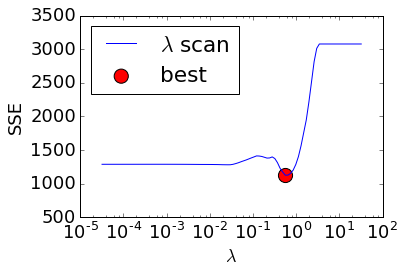

In [3]:
penalties, SSE = lasso_CV(A,y)
ind = np.argsort(SSE)[0]
best_penalty = penalties[ind]
lowest_SSE = SSE[ind]

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogx(penalties, SSE, label=r'$\lambda$ scan')
ax.scatter(best_penalty, lowest_SSE, s=200, c=[1,0,0],label='best')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('SSE')
plt.legend(loc='upper left',scatterpoints=1)
plt.show()
plt.close()

The best $\lambda$ is just under $1$. Let's see if the model learned with the best penalty matches the true model used to generate the data set:

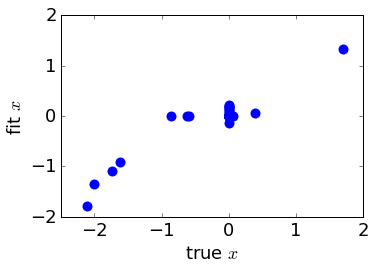

In [4]:
clf = Lasso(alpha=best_penalty)
clf.fit(A, y)
x_fit = clf.coef_
fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.scatter(x_true, x_fit, s=100, lw=0)
ax.set_xlabel(r'true $x$')
ax.set_ylabel(r'fit $x$')
ax.set_xticks(range(-2,3))
ax.set_yticks(range(-2,3))
plt.show()
plt.close()

Well, the recovery isn't perfect, and part of this is because I've put a relatively strong noise term on a relatively small sample size. So how much can I trust these terms? I have a lot of fit $x$ terms that are non-zero. Is there some sort of way to measure my uncertainty with this fit? Here's where I introduce the Bayesian Lasso. I've implemented Bayesian Lasso as described by https://stackoverflow.com/questions/28290249/bayesian-lasso-using-pymc3, although I've tried to make the usage a bit more automatic. 

In [5]:
from lasso_PyMC3 import lasso
non_zero = x_fit != 0
trace, C, delta = lasso(A[:, non_zero],y, 10000, best_penalty)

Laplace('x0', 0, b=0.559703) * X[:,0] +Laplace('x1', 0, b=0.559703) * X[:,1] +Laplace('x2', 0, b=0.559703) * X[:,2] +Laplace('x3', 0, b=0.559703) * X[:,3] +Laplace('x4', 0, b=0.559703) * X[:,4] +Laplace('x5', 0, b=0.559703) * X[:,5] +Laplace('x6', 0, b=0.559703) * X[:,6] +Laplace('x7', 0, b=0.559703) * X[:,7] +Laplace('x8', 0, b=0.559703) * X[:,8] +Laplace('x9', 0, b=0.559703) * X[:,9] +Laplace('x10', 0, b=0.559703) * X[:,10] +Laplace('x11', 0, b=0.559703) * X[:,11] +Laplace('x12', 0, b=0.559703) * X[:,12] +Laplace('x13', 0, b=0.559703) * X[:,13] +Laplace('x14', 0, b=0.559703) * X[:,14] +Laplace('x15', 0, b=0.559703) * X[:,15] +Laplace('x16', 0, b=0.559703) * X[:,16] +Laplace('x17', 0, b=0.559703) * X[:,17] 
Optimization terminated successfully.
         Current function value: 313.439443
         Iterations: 24
         Function evaluations: 39
         Gradient evaluations: 39


100%|██████████| 10500/10500 [01:20<00:00, 131.20it/s]


C is a matrix of parameter values. delta is the number of iterations where autocorrelations drops to 10%. trace is the output from sampling PyMC3. This algorithm was run for 10000 iterations.

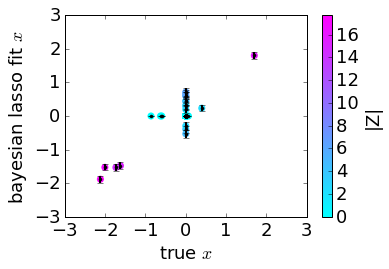

In [6]:
x_bayesian = np.zeros(x_fit.shape)
x_bayesian_std = np.zeros(x_fit.shape)

x_bayesian[non_zero] = np.mean(C[500::delta], axis=0)
x_bayesian_std[non_zero] = np.std(C[500::delta], axis=0)
Z = x_bayesian / (x_bayesian_std + (x_bayesian_std == 0))

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
cax = ax.scatter(x_true, x_bayesian, c=np.abs(Z), s=50, zorder=9, cmap='cool', lw=0)
ax.errorbar(x_true, x_bayesian, yerr=x_bayesian_std,fmt='.', lw=2, zorder=10, c=[0,0,0])
cbar = plt.colorbar(cax)
cbar.set_label('|Z|')
ax.set_xlabel(r'true $x$')
ax.set_ylabel(r'bayesian lasso fit $x$')
ax.set_xticks(range(-3,4))
ax.set_yticks(range(-3,4))
plt.show()
plt.close()

I've also implemented this method with emcee, using the log likelihood function in Park and Casella (1). Specifically, I used the log likelihood
\begin{align}
LL= \frac{m + n+1}{2}\text{ln} \left [\frac{1}{\sigma^2} \right] +\frac{1}{2\sigma^2} \left ( \mathbf{A\cdot x - y} \right)^T \cdot \left ( \mathbf{A\cdot x - y} \right) - \frac{\lambda}{\sigma} \sum_i^n |x_i|
\end{align}
What kind of result does that give?

1. Park, T. and Casella, G. (2008). The bayesian lasso. Journal of the American Statistical Association, 103(482):681–686. 

In [7]:
from bayesian_lasso_emcee import bayesian_lasso
mu, sigma, p, sample_rate = bayesian_lasso(A[:,non_zero],y, best_penalty, x_fit[non_zero])

Bayesian_lasso returns the mean parameter values (mu), standard deviation (sigma), the probability of switching signs (p), and the sampling rate where autocorrelation drops to 10%. I've written it to automatically include a burn in period. 

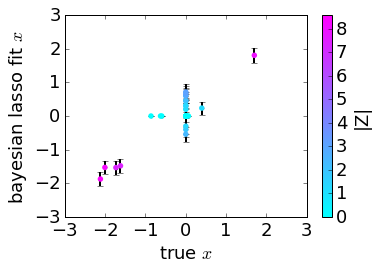

In [8]:
x_bayesian_emcee = np.zeros(x_fit.shape)
x_bayesian_std_emcee = np.zeros(x_fit.shape)
x_bayesian_p_emcee = np.zeros(x_fit.shape)

x_bayesian_emcee[non_zero] = mu
x_bayesian_std_emcee[non_zero] = sigma
Z_emcee = x_bayesian_emcee / (x_bayesian_std_emcee + (x_bayesian_std_emcee == 0))

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
cax = ax.scatter(x_true, x_bayesian_emcee, c=np.abs(Z_emcee), s=30, zorder=11, cmap='cool', lw=0)
ax.errorbar(x_true, x_bayesian_emcee, yerr=x_bayesian_std_emcee,fmt='.', lw=2, zorder=10, c=[0,0,0])
cbar = plt.colorbar(cax)
cbar.set_label('|Z|')
ax.set_xlabel(r'true $x$')
ax.set_ylabel(r'bayesian lasso fit $x$')
ax.set_xticks(range(-3,4))
ax.set_yticks(range(-3,4))
plt.show()
plt.close()

This result seems pretty similar to the PyMC3 method. Let's see how the two compare to each other:

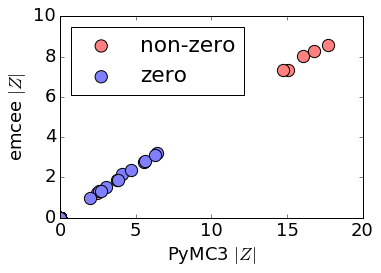

In [10]:
from scipy.stats import norm
true_non_zero = x_true!=0
true_zero = x_true==0


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
cax = ax.scatter(np.abs(Z[true_non_zero]), np.abs(Z_emcee[true_non_zero]), s=150, c=[1,0.5,0.5], label='non-zero')
cax = ax.scatter(np.abs(Z[true_zero]), np.abs(Z_emcee[true_zero]), s=150, c=[0.5,0.5,1], label='zero')
plt.legend(loc='upper left', scatterpoints=1)
ax.set_xlabel(r'PyMC3 $|Z|$')
ax.set_ylabel(r'emcee $|Z|$')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.show()
plt.close()

Both emcee and PyMC3 methods give nearly perfectly correlated Z scores. However, emcee tends to give lower Z scores. I'm more inclined to trust the emcee scaling since PyMC3 does call Z scores up to 6-7 standard deviations for null parameters. My emcee implementation calls Z-scores in the 3-4 range for null parameters. Considering that I had 490 null parameters, finding a few parameters around 3-4 standard deviations seems fair, since this corresponds to what you would see from sampling a random normal distribution between 185 to 7142 times. 

I'm not really sure why this happens, because PyMC3 is a bit of a black box to me. However, in the Bayesian Lasso Log Likelihood formula, this term
\begin{align}
\frac{m + n+1}{2}\text{ln} \left [\frac{1}{\sigma^2} \right]
\end{align}
strongly affects the $\sigma$ term that I find. Larger coefficients (e.g. $1000 \cdot \frac{m + n+1}{2}\text{ln} \left [\frac{1}{\sigma^2} \right]$) are going to make emcee more confident about non-zero results, which could affect the scaling.